In [1]:
import json
import pandas as pd
from pathlib import Path

# Load the consolidated fixed issues JSONL file
jsonl_path = Path("../results/fixed_issues/all_fixed_issues.jsonl")

fixed_issues_data = []
failed_entries = []

with open(jsonl_path, 'r', encoding='utf-8') as f:
    for line_num, line in enumerate(f, 1):
        line = line.strip()
        if not line:
            continue
        try:
            entry = json.loads(line)
            # Check if this is a successful entry (has fixedIssues) or a failed entry
            if 'fixedIssues' in entry:
                fixed_issues_data.append(entry)
            else:
                failed_entries.append(entry)
        except json.JSONDecodeError as e:
            print(f"Error parsing line {line_num}: {e}")
            print(f"Line content: {line[:200]}...")

print(f"Loaded {len(fixed_issues_data)} successful entries")
print(f"Loaded {len(failed_entries)} failed entries")
print(f"Total entries: {len(fixed_issues_data) + len(failed_entries)}")

# Create DataFrames
if fixed_issues_data:
    df_fixed_issues = pd.DataFrame(fixed_issues_data)
    print(f"\nSuccessful entries DataFrame shape: {df_fixed_issues.shape}")
    print(f"Columns: {df_fixed_issues.columns.tolist()}")
    
if failed_entries:
    df_failed = pd.DataFrame(failed_entries)
    print(f"\nFailed entries DataFrame shape: {df_failed.shape}")
    print(f"Columns: {df_failed.columns.tolist()}")


Loaded 461612 successful entries
Loaded 34469 failed entries
Total entries: 496081

Successful entries DataFrame shape: (461612, 4)
Columns: ['slug', 'fixedIssues', 'fixedIssuesCount', 'fetched_at']

Failed entries DataFrame shape: (34469, 4)
Columns: ['slug', 'error', 'status_code', 'failed_at']


In [7]:
# Explode the fixedIssues list into multiple rows
# Explode so each fixed issue dict gets its own row, and then expand the dict into columns
df_fixed_issues_exploded = (
    df_fixed_issues
    .explode("fixedIssues")                      # One row per fixedIssue dict
    .reset_index(drop=True)
)

# Expand the fixedIssues column, which is now a dict, into separate columns
fixed_issues_details = pd.json_normalize(df_fixed_issues_exploded["fixedIssues"])
df_fixed_issues_exploded = pd.concat(
    [df_fixed_issues_exploded.drop(columns=["fixedIssues"]), fixed_issues_details], axis=1
)

In [ ]:
df_fixed_issues_exploded

,slug,fixedIssuesCount,fetched_at,criticality,issueType,problematicText,explanation,fixedText,evidenceSource
0,T20_(classification),8,2025-11-13T18:05:01.011703,Critical,Timeliness/Currency,Onset acquired before the age of 18,The eligibility criteria for T20 classificatio...,"Update the onset age to ""before age 22"" and at...",[](https://www.paralympic.org/athletics/classi...
1,T20_(classification),8,2025-11-13T18:05:01.011703,Critical,Source/Citation Mismatch,The International Paralympic Committee defined...,Reference [3] is from 2016 and lacks detail; c...,"Update to current IPC definition: ""T20 is a sp...",[](https://www.paralympic.org/athletics/classi...
2,T20_(classification),8,2025-11-13T18:05:01.011703,Critical,Missing Information,[No specific text; overall section lacks curre...,The section omits key current requirements for...,Add brief description of current eligibility p...,[](https://www.paralympic.org/athletics/classi...
3,T20_(classification),8,2025-11-13T18:05:01.011703,Critical,Scope/Applicability Misstatement,"Internationally, events open to this class inc...",Shot put is a throwing event and belongs to th...,Revise the list to accurately reflect Paralymp...,IPC Athletics Classification & Categories [3];...
4,T20_(classification),8,2025-11-13T18:05:01.011703,Critical,Timeliness/Currency,The table referencing 2016 Summer Paralympics ...,The table presents qualification standards fro...,Update the table to reflect the 2024 Paris Par...,Paris 2024 Paralympic Games Qualification Regu...
...,...,...,...,...,...,...,...,...,...
4288097,Etiology,3,2025-11-13T21:48:15.001685,Critical,Quantitative/Units Error,It took about another two hundred years to dis...,The timeline is inaccurate. Captain Cook's rel...,"Change to: ""It took over 150 years to discover...",[](https://www.sciencelearn.org.nz/resources/1...
4288098,Etiology,3,2025-11-13T21:48:15.001685,Critical,Missing Information,The following are examples of intrinsic factor...,The section lists only intrinsic (internal) fa...,Add a parallel list of extrinsic factors examp...,[3] or [](https://study.com/academy/lesson/eti...
4288099,White_House_swimming_pool,3,2025-11-13T21:48:15.001687,Critical,Quantitative/Units Error,The 20-foot (6.1 m) wide and 50-foot (15 m) lo...,The stated dimensions are approximate planned ...,Update to: The 22-foot (6.7 m) wide and 54-foo...,White House Historical Association: https://ww...
4288100,White_House_swimming_pool,3,2025-11-13T21:48:15.001687,Critical,Mechanism/Specification Error,A cabana was later added to the pool,The cabana was constructed simultaneously with...,Change to: A cabana was added to the pool,White House Museum (archived): https://web.arc...


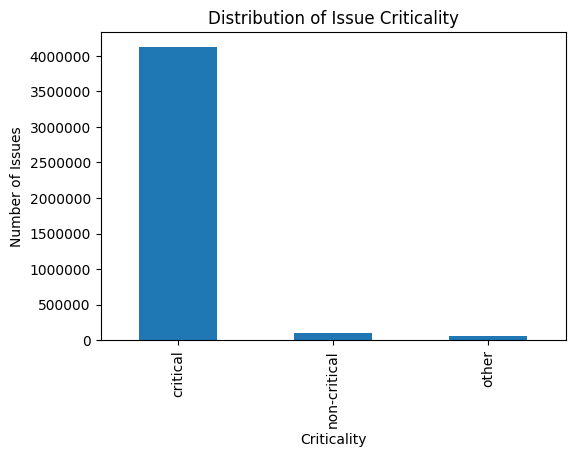

In [15]:
import matplotlib.pyplot as plt

def criticality_category(val):
    if pd.isna(val):
        return "other"
    if str(val).lower() == "critical":
        return "critical"
    if str(val).lower() == "non-critical":
        return "non-critical"
    return "other"

criticality_grouped = df_fixed_issues_exploded["criticality"].map(criticality_category)
counts = criticality_grouped.value_counts().reindex(["critical", "non-critical", "other"]).fillna(0)

plt.figure(figsize=(6,4))
ax = counts.plot(kind="bar")
plt.xlabel("Criticality")
plt.ylabel("Number of Issues")
plt.title("Distribution of Issue Criticality")
ax.ticklabel_format(style='plain', axis='y')
plt.show()

In [18]:
type_counts = df_fixed_issues_exploded["issueType"].value_counts().sort_values(ascending=False)

In [21]:
type_counts[:25]

issueType
Missing Information                                            1250714
Source/Citation Mismatch                                       1226755
Timeliness/Currency                                             643373
Quantitative/Units Error                                        334094
Scope/Applicability Misstatement                                215726
Figures/Tables/Data Presentation                                208099
Mechanism/Specification Error                                   194521
Internal Contradiction                                          126432
Factual Inaccuracy                                               13895
Factual Error                                                    11981
Mathematical Correctness (Proof/Definition)                       9103
Source/Citation Mismatch | Timeliness/Currency                    6067
Safety/Health Risk                                                3764
Critical Factual Error                                            2

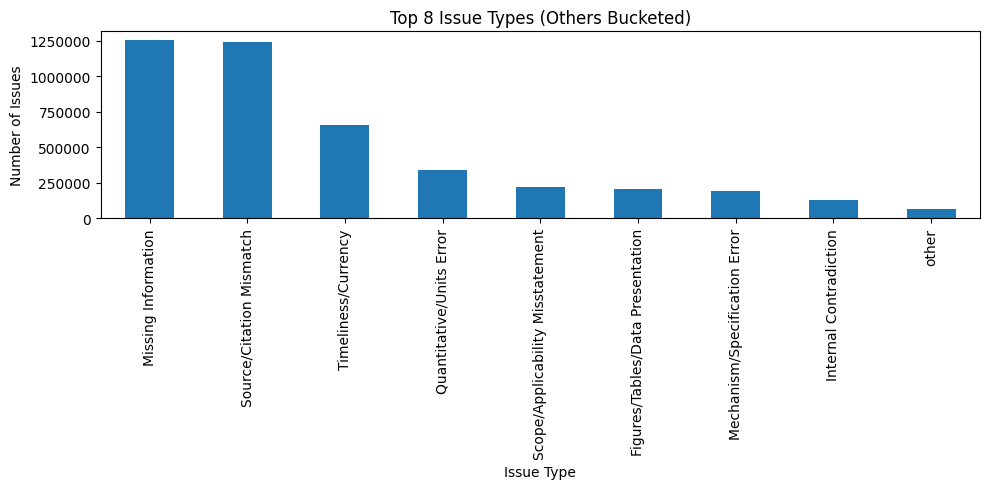

In [25]:
import matplotlib.pyplot as plt

def issue_type_category(val):
    if pd.isna(val):
        return ["other"]
    val_str = str(val).strip()
    if not val_str:
        return ["other"]
    # If value contains a pipe, split and assign both categories
    if "|" in val_str:
        return [x.strip() for x in val_str.split("|") if x.strip()]
    return [val_str]

issue_type_grouped = df_fixed_issues_exploded["issueType"].map(issue_type_category)

# Flatten the list of types for counting
from collections import Counter

all_types = [t for sublist in issue_type_grouped for t in sublist]
type_counter = Counter(all_types)
top_15 = [t for t, _ in type_counter.most_common(8)]

# Bucket: map to 'other' if not in top 15
def bucket_type(tlist):
    return [x if x in top_15 else "other" for x in tlist]

bucketed_types = [bucket_type(tlist) for tlist in issue_type_grouped]
flattened_bucketed_types = [t for sublist in bucketed_types for t in sublist]
final_type_counts = pd.Series(flattened_bucketed_types).value_counts()

plt.figure(figsize=(10,5))
ax = final_type_counts.plot(kind="bar")
plt.xlabel("Issue Type")
plt.ylabel("Number of Issues")
plt.title("Top 8 Issue Types (Others Bucketed)")
ax.ticklabel_format(style='plain', axis='y')
plt.tight_layout()
plt.show()
